## Covid and ibd sentiment analysis  <a class='anchor' id='top'></a>

- [Algorithm comparison](#alg-comp) 
- [Sentiment Analysis on **unfiltered** data](#sentiment)
- [Sentiment Analysis on **filtered** data](#sentiment-filtered)
    - [Introducing roBERTa](#roberta)
    - [When do roBERTa and vader get on?](#vader-geton-rob)
- [Frequency Distribution on **filtered data**](#freq-dist)
- [Concordances and Quadgrams](#conc-quad)
- [Wordclouds](#wordcloud)
- [RegExr specific filtering](#reg-filter)

In [1]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import os
import re
import string
import nltk
import datetime as dt
from termcolor import colored

from statistics import mean
from tqdm.notebook import tqdm,tnrange
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer as SIA_VADER
from nltk.sentiment import SentimentIntensityAnalyzer as SIA_NLTK

import matplotlib 
import matplotlib.pyplot as plt
import matplotlib.style as style 
import seaborn as sns

sns.set_style('darkgrid')
sns.set_context('paper')
style.use('ggplot')
matplotlib.rcParams['font.family'] = 'helvetica'
matplotlib.rcParams['figure.titlesize'] = 'large'

In [2]:
def import_submissions_df():
    path = './submissions_scraped/'
    files = []
    for filename in os.listdir(path):
        files.append(pd.read_csv(os.path.join(path, filename)))

    files = pd.concat(files)
    df_submissions = pd.DataFrame(files)
    df_submissions.drop(columns=['Unnamed: 0'], inplace=True)
    df_submissions.dropna(inplace=True)
    return df_submissions

In [3]:
def import_comments_df():
    df_comments = pd.read_csv('./comments_scraped/comments.csv')
    df_comments.drop(columns=['Unnamed: 0'], inplace=True)
    df_comments.dropna(inplace=True)
    return df_comments

In [4]:
def clean_text(text): 
    text = text.replace('\r', '').replace('\n', ' ').replace('\n', ' ').lower()
    text = re.sub('^\[removed\]|^\[deleted\]', '', str(text))
    text = re.sub('^\[deleted by user\]', '', str(text))
    text = re.sub('^nan', '', str(text))
    text = re.sub(r'#', '',  str(text))
    text = re.sub(r"(?:\@|https?\://)\S+", "", str(text))
    text = re.sub(r'[^\x00-\x7f]',r'', str(text))
    text = re.sub(r'www\S+', '',  str(text)) 
    banned_list= string.punctuation + 'Ã'+'±'+'ã'+'¼'+'â'+'»'+'§'
    table = str.maketrans('', '', banned_list)
    text = text.translate(table)
    return text

In [5]:
def is_positive(compound):
    if compound > 0.05:
        return 1
    elif compound < -0.05:
        return -1
    else:
        return 0

In [6]:
subreddits = ['CrohnsDisease', 'IBD', 'UlcerativeColitis', 'ibs']
colors = ['#cc5a49', '#4586ac', '#9e97cc', '#777777']

df_submissions = import_submissions_df()
df_comments = import_comments_df()

df_submissions = df_submissions[df_submissions['body'] != '']
df_comments = df_comments[df_comments['body'] != '']

df_submissions['created'] = pd.to_datetime(df_submissions['created'])
df_comments['created'] = pd.to_datetime(df_comments['created'])

In [7]:
df = pd.concat([df_submissions, df_comments])
df.body = df.body.apply(lambda x: clean_text(str(x)))
df.title = df.title.apply(lambda x: clean_text(str(x)))

In [8]:
df['title_and_body'] = df['title'] + ' ' + df['body']
df['title_and_body'] = df['title_and_body'].apply(lambda x: clean_text(x))
df = df[df['title_and_body'] != '']

### Analysis of data usign vader, nltk and nltk with tokenization <a class='anchor' id='alg-comp'></a>

In [9]:
sia_vader = SIA_VADER()
sia_nltk = SIA_NLTK()

In [10]:
sentiments = []
for post in tqdm(df.title_and_body, desc='Analyzing with vader'):
    sentiments.append(sia_vader.polarity_scores(post))
    
df['sia_vader'] = sentiments

compounds = []
for sent_dict in df.sia_vader.iloc[0:]:
    compounds.append(sent_dict['compound'])

df['compound_vader'] = compounds

Analyzing with vader:   0%|          | 0/379573 [00:00<?, ?it/s]

In [11]:
sentiments = []
for post in tqdm(df.title_and_body, desc='Analyzing with nltk'):
    sentiments.append(sia_nltk.polarity_scores(post))

df['sia_nltk'] = sentiments

compounds = []
for sent_dict in df.sia_vader.iloc[0:]:
    compounds.append(sent_dict['compound'])

df['compound_nltk'] = compounds

Analyzing with nltk:   0%|          | 0/379573 [00:00<?, ?it/s]

In [12]:
df['label_vader'] = df.compound_vader.apply(lambda x: is_positive(x))
df['label_nltk'] = df.compound_nltk.apply(lambda x: is_positive(x))

In [114]:
def is_positive_2(text):        
    scores = [
        sia_nltk.polarity_scores(sentence)['compound'] 
        for sentence in nltk.sent_tokenize(text)
    ]
    if len(scores) > 0:
        if mean(scores) > 0.1:
            return 1
        elif mean(scores) < -0.1:
            return -1
        else:
            return 0
    else:
        return 0

In [120]:
# Take positives and check pos, neu, neg 


text = 'Hello I hope to go to the doctor'

print(sia_vader.polarity_scores(text))

{'neg': 0.0, 'neu': 0.707, 'pos': 0.293, 'compound': 0.4404}


The whole text is break down in sentences, sia_nltk evaluates the single sentcence

In [115]:
sentiments = []
for text in tqdm(df.title_and_body.iloc[0:], desc='Analyzing with nltk and tokenization'):
    sentiments.append(is_positive_2(text))

df['label_nltk_with_tokens'] = sentiments

Analyzing with nltk and tokenization:   0%|          | 0/379573 [00:00<?, ?it/s]

In [116]:
print(colored('Algorithm comparison result', color='blue'), '\n')
print(df.label_vader.value_counts(), '\n')
print(df.label_nltk.value_counts(), '\n')
print(df.label_nltk_with_tokens.value_counts(), '\n')

Algorithm comparison result 

 1    190666
-1    126406
 0     62501
Name: label_vader, dtype: int64 

 1    190666
-1    126406
 0     62501
Name: label_nltk, dtype: int64 

 1    183363
-1    123813
 0     72397
Name: label_nltk_with_tokens, dtype: int64 



There is no much difference between the algorithms.  
The tokenization seems to produce similar results

In [117]:
%%capture

df_nltk_with_tokens = df[['label_nltk_with_tokens', 'created']]
df_nltk = df[['label_nltk', 'created']]
df_vader = df[['label_vader', 'created']]

df_nltk_with_tokens['algorithm'] = 'nltk with tokenization'
df_vader['algorithm'] = 'vader'
df_nltk['algorithm'] = 'nltk'

df_nltk_with_tokens.rename(columns={'label_nltk_with_tokens': 'label'}, inplace=True)
df_vader.rename(columns={'label_vader': 'label'}, inplace=True)
df_nltk.rename(columns={'label_nltk': 'label'}, inplace=True)

df_results = pd.concat([df_nltk, df_vader, df_nltk_with_tokens], ignore_index=True)

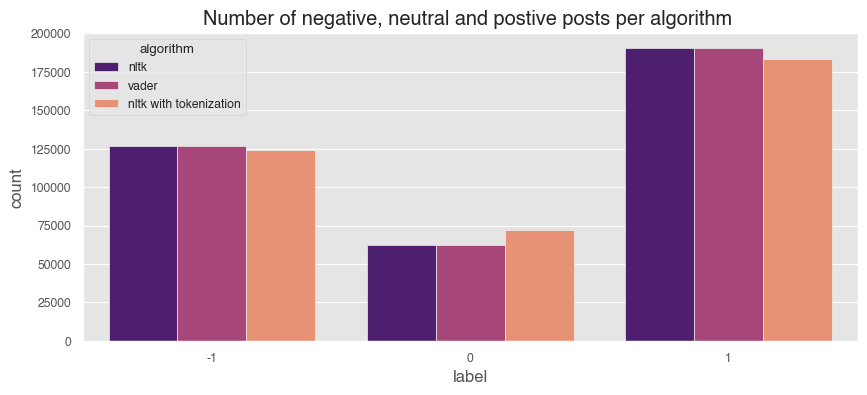

In [118]:
fig, ax = plt.subplots(figsize=(10,4))

sns.countplot(x='label', hue='algorithm', data=df_results, palette='magma')
plt.title('Number of negative, neutral and postive posts per algorithm ')
plt.show();

# length of posts
# sub vs comments

From now the analysis the main algorithm will be **vader** 

### Sentiment Analysis on unfiltered data <a class='anchor' id='sentiment'></a>

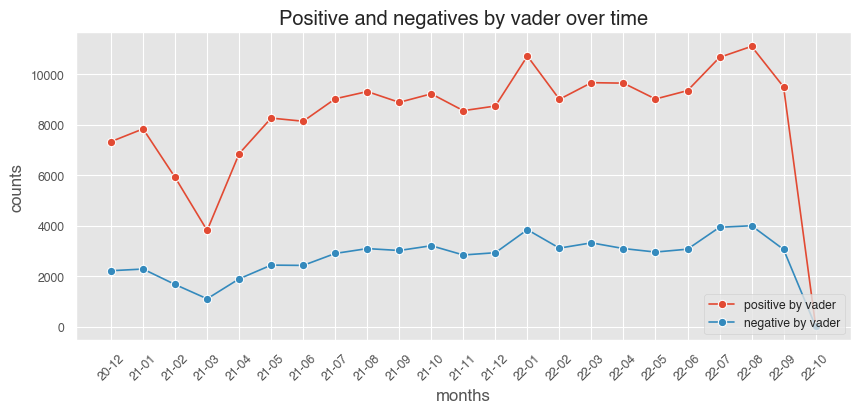

In [18]:
v_pos = df_vader[df_vader['label'] == 1]
v_neg = df_vader[df_vader['label'] == 0]

v_pos = v_pos['created'].dt.strftime('%y-%m').value_counts().sort_index().reset_index(name='counts')
v_neg = v_neg['created'].dt.strftime('%y-%m').value_counts().sort_index().reset_index(name='counts')

df_v_pos = pd.DataFrame(v_pos)
df_v_neg = pd.DataFrame(v_neg)

df_v_pos = df_v_pos.rename(columns={'index': 'months'}).reset_index()
df_v_neg = df_v_neg.rename(columns={'index': 'months'}).reset_index()

plt.figure(figsize=(10, 4))
plt.title('Positive and negatives by vader over time')
sns.lineplot(x=df_v_pos.months, y=df_v_pos.counts, marker='o', markersize=6, label='positive by vader');
sns.lineplot(x=df_v_neg.months, y=df_v_neg.counts, marker='o', markersize=6, label='negative by vader')
plt.xticks(rotation = 45)

plt.legend(loc='lower right')
plt.show();

The plot shows that much more data are labelled as positive than negative.  

There is a max and min peek between **December 2021** and **February 2022**. Then another one during **July and August 2022**. 

In [19]:
compound_vader = []
for entry in df.sia_vader:
    compound_vader.append(entry['compound'])

df_vader['compound'] = compound_vader

In [20]:
df_vader.created = df_vader.created.apply(lambda x : x.strftime('%y-%m'))

sentiment_by_month = df_vader.groupby('created').sum('compound').compound.values
number_of_posts_over_time = df_vader.groupby('created').count().compound.values
avg_sentiments = []
for i in range(0, len(sentiment_by_month)):
    avg_sentiments.append(sentiment_by_month[i] / number_of_posts_over_time[i])

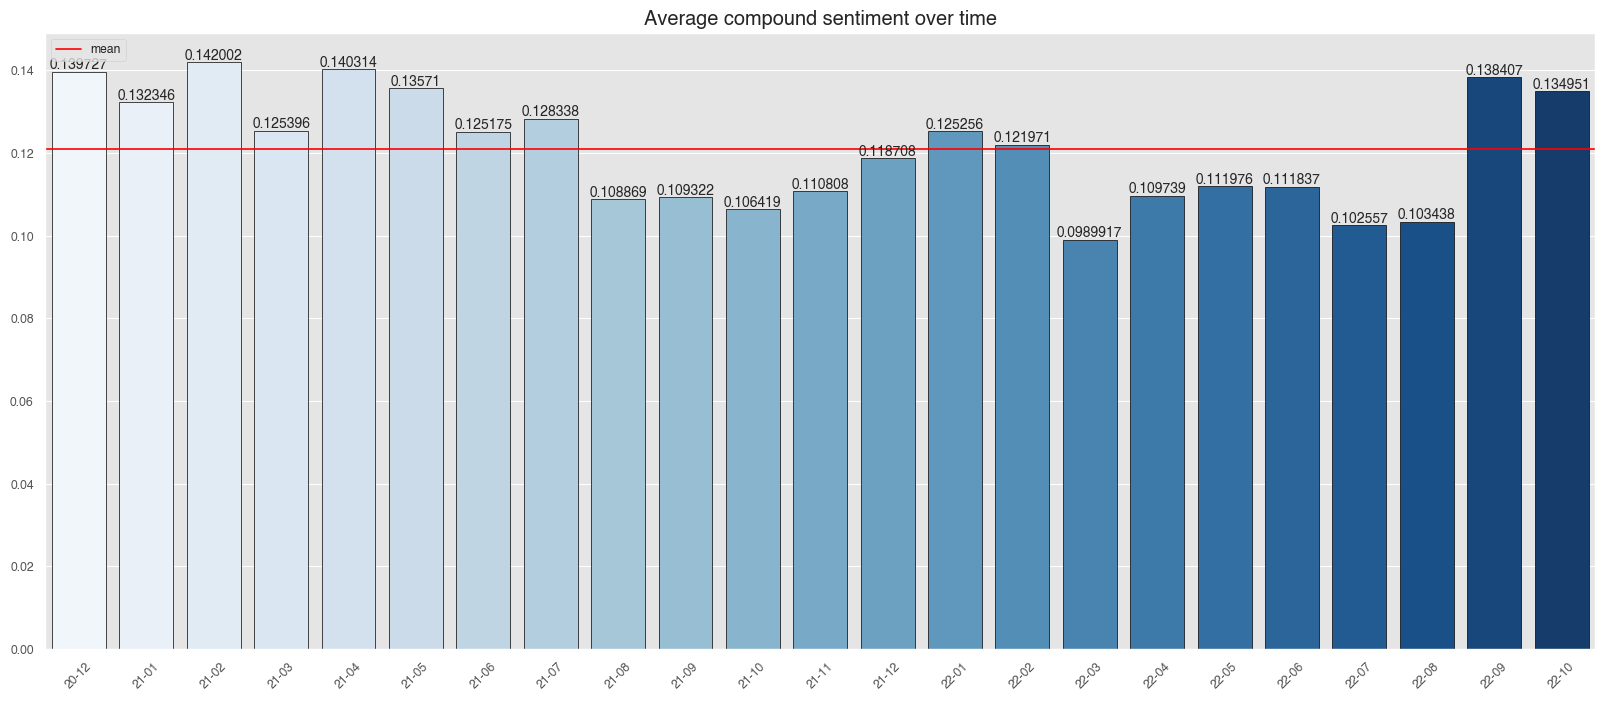

In [21]:
fig, ax = plt.subplots(figsize=(20,8))
plt.title('Average compound sentiment over time')
sns.barplot(x=df_vader.groupby('created').count().compound.keys(), y=avg_sentiments, edgecolor='black', palette='Blues', ax=ax)
plt.xticks(rotation=45)
ax.set_xlabel('')
plt.axhline(mean(avg_sentiments), color='r', label='mean')
ax.bar_label(ax.containers[0])

plt.legend(loc='upper left')
plt.show();

What we could see is that between **August 2021** and **August 2022** the average compound sentiment is slightly under the mean compound.  

The min peek is in **March 2022**.  

It was a key period during the last waves of the pandemic beacuse covid cases increased exponentially as shown [here](https://covid19.who.int).


In [22]:
pos_per_month = df_vader[df_vader['label'] == 1].groupby('created').count().label
neg_per_month = df_vader[df_vader['label'] == -1].groupby('created').count().label
number_of_posts_over_time = df_vader.groupby('created').count().compound.values

pos_rate_per_month = []
neg_rate_per_month = []
for i in range(len(pos_per_month)):
    neg_rate_per_month.append(neg_per_month[i] / number_of_posts_over_time[i])
    pos_rate_per_month.append(pos_per_month[i] / number_of_posts_over_time[i])
    
dates = df_vader.groupby('created').count().compound.keys()
df_rates = pd.DataFrame({
    'pos_rate': pos_rate_per_month,
    'neg_rate': neg_rate_per_month,
    'date': dates
})

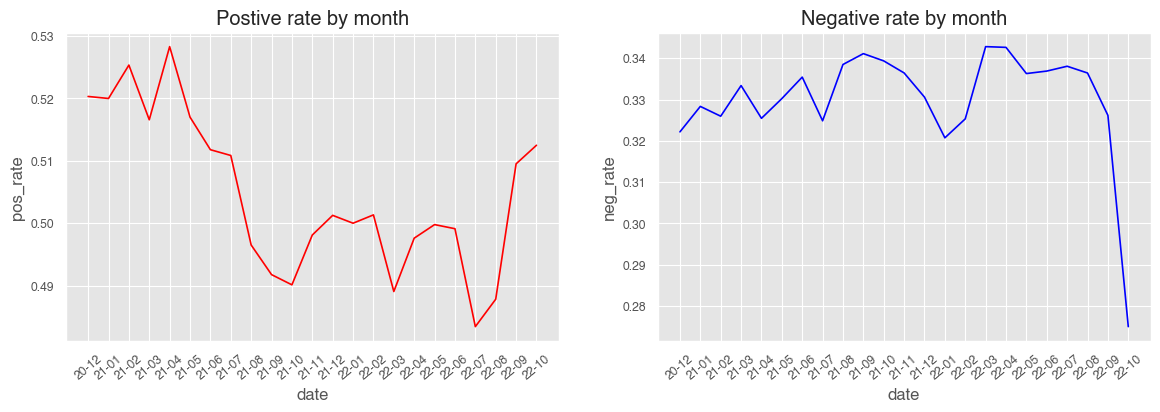

In [23]:
fig, [ax1, ax2] = plt.subplots(figsize=(14,4), ncols=2, nrows=1)

plt.setp(ax1.xaxis.get_majorticklabels(), rotation=40)
ax1.set_title('Postive rate by month')
sns.lineplot(x='date', y='pos_rate', data=df_rates, ax=ax1, color='r')

plt.setp(ax2.xaxis.get_majorticklabels(), rotation=40)

ax2.set_title('Negative rate by month')
sns.lineplot(x='date', y='neg_rate', data=df_rates, ax=ax2, color='b')

plt.show();

# scale to 0-1
# sns.plot.area()

It's shown the rate of positives and negatives post by month.   
The plot on the left shows how the postive rate of posts drops after **July 2021**, on the right instead the negative rate seems pretty constant except the downfall in the last month, which could be an outlier considering there are much less post in that month (only 80 post retrieved for 10-22)

In [24]:
df_subr = df[['label_vader', 'created', 'subreddit']]
df_subr.rename(columns={'label_vader': 'label'}, inplace=True)

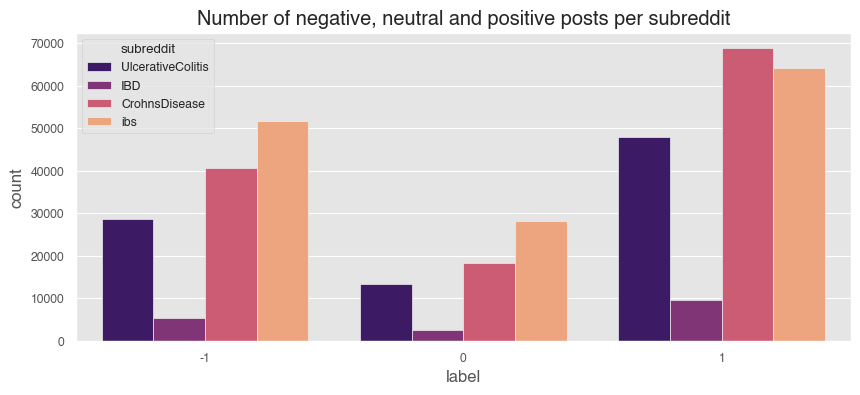

In [25]:
fig, ax = plt.subplots(figsize=(10,4))

sns.countplot(x='label', hue='subreddit', data=df_subr, palette='magma')
plt.title('Number of negative, neutral and positive posts per subreddit')
plt.show();

**r/CrohnsDisease** is the subreddit with more postive texts despite having much less data than **r/ibs**.

For further investigation let's check the actual **sentiment rate** for each subreddit. 

In [26]:
rates = []
for sr in subreddits:
    dd = df_subr[df_subr['subreddit'] == sr]
    dd_pos = dd[dd['label'] == 1]
    dd_neg = dd[dd['label'] == -1]
    dd_neu = dd[dd['label'] == 0]
    pos_rate = dd_pos.shape[0] / df[df['subreddit'] == sr].shape[0]
    neg_rate = dd_neg.shape[0] / df[df['subreddit'] == sr].shape[0]
    neu_rate = dd_neu.shape[0] / df[df['subreddit'] == sr].shape[0]
    
    rates.append((pos_rate, sr, 1))
    rates.append((neg_rate, sr, -1))
    rates.append((neu_rate, sr, 0))
    
rates = pd.DataFrame(rates, columns=['rate', 'subreddit', 'label'])

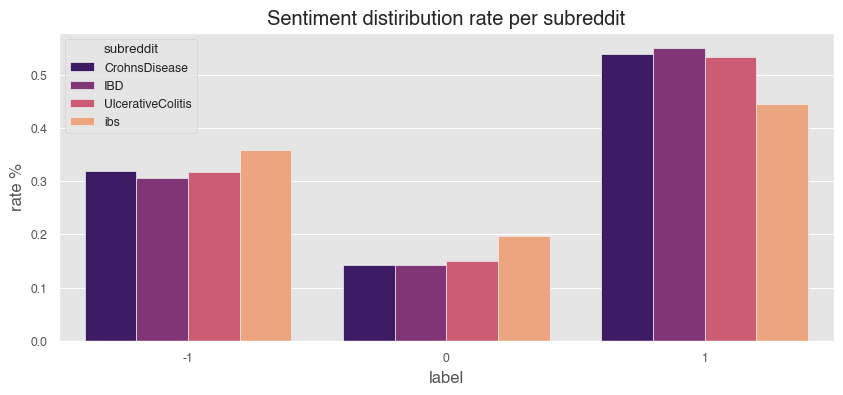

In [27]:
fig, ax = plt.subplots(figsize=(10,4))

sns.barplot(data=rates, x='label', y='rate', hue='subreddit', palette='magma', ax=ax)
plt.title('Sentiment distiribution rate per subreddit')
ax.set_ylabel('rate %')
plt.show();

As shown above the sentiment rate changes the perception that we had. 
 
**r/IBD** is the most positive considering the amount of data that it holds.  

**r/ibs** it the most negative but not with the discrepancy shown above.

In [28]:
df_pos_vs_neg_vad = df[['label_vader', 'created']]
df_pos_vs_neg_vad.rename(columns={'label_vader': 'label'}, inplace=True)
df_pos_vs_neg_vad.created = df_pos_vs_neg_vad.created.apply(lambda x: x.strftime('%y-%m'))

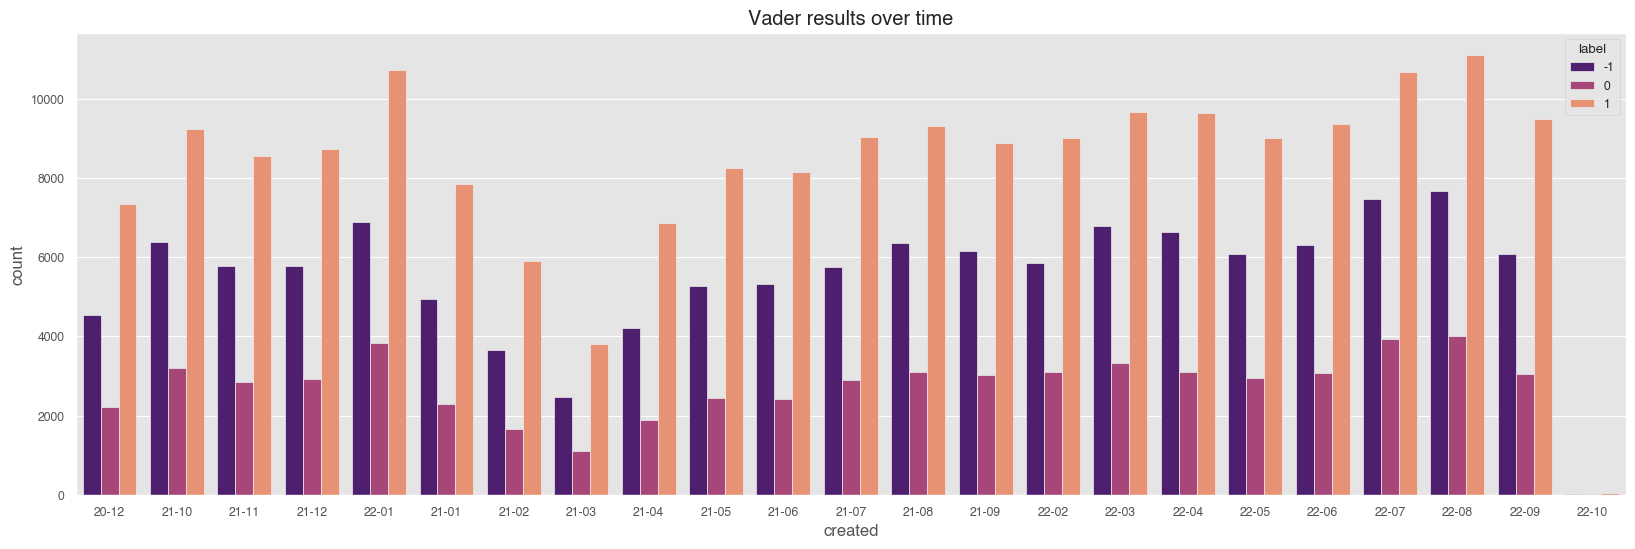

In [29]:
fig, ax = plt.subplots(figsize=(20,6))

sns.countplot(x='created', hue='label', data=df_pos_vs_neg_vad, palette='magma')
plt.title('Vader results over time')
plt.show();

In [30]:
topfive_positive = df[df['compound_vader'] > 0.9].sort_values(['compound_vader','score'], ascending=False).iloc[0:5]
topfive_positive = topfive_positive[['author', 'score', 'body', 'compound_vader']]

display(topfive_positive)

,author,score,body,compound_vader
409,Health-n-Happiness,29,hopefully the conclusive thread for all your ...,0.9999
12055,Regular_Toast_Crunch,5,it makes sense to be nervous its a big thing a...,0.9997
387,Michento,34,this is really long there is no tldr ive tried...,0.9996
125337,ChronicEverythingMom,1,i suffer from ibd epi myself and i am mother ...,0.9996
29401,altairnaruhodou,18,hello fellow sufferers ibs patient here with ...,0.9995


In [31]:
topfive_negative = df[df['compound_vader'] < 0.9].sort_values(['compound_vader','score'], ascending=True).iloc[0:5]
topfive_negative = topfive_negative[['author', 'score', 'body', 'compound_vader']]

display(topfive_negative)

,author,score,body,compound_vader
16936,Experiment413,6,hi im angel im new to this reddit and i though...,-0.9999
21831,regionalcryptid,6,hey everyone ive come here because i really fe...,-0.9999
13437,Maybe_Thrwwy,5,i know these sort of posts can be very long so...,-0.9996
683,tummypainthrowaway,7,tldr rather sudden onset of symptoms what you ...,-0.9996
31470,DeathbyMuzak,1,hello all first let me say that i am so very...,-0.9994


In [32]:
df[df['label_vader'] == 1].score.sum()

826004

In [33]:
df[df['label_vader'] == -1].score.sum()

645709

In [34]:
df[df['label_vader'] == 0].score.sum()

215593

It seems that the **positive** submissions or comments, earn much more upvotes

In [35]:
df_subr['compound'] = df[['compound_vader']]

df_crohns = df_subr[df_subr['subreddit'] == 'CrohnsDisease']
df_ibd = df_subr[df_subr['subreddit'] == 'IBD']
df_ibs = df_subr[df_subr['subreddit'] == 'ibs']
df_ulc = df_subr[df_subr['subreddit'] == 'UlcerativeColitis']

df_crohns.created = df_crohns.created.apply(lambda x : x.strftime('%y-%m'))
df_ibd.created = df_ibd.created.apply(lambda x : x.strftime('%y-%m'))
df_ibs.created = df_ibs.created.apply(lambda x : x.strftime('%y-%m'))
df_ulc.created = df_ulc.created.apply(lambda x : x.strftime('%y-%m'))

sentiment_crohn_by_month = df_crohns.groupby('created').sum('compound').compound.values
sentiment_ibd_by_month = df_ibd.groupby('created').sum('compound').compound.values
sentiment_ibs_by_month = df_ibs.groupby('created').sum('compound').compound.values
sentiment_ulc_by_month = df_ulc.groupby('created').sum('compound').compound.values

number_of_posts_over_time_crohn = df_crohns.groupby('created').count().compound.values
number_of_posts_over_time_ibd = df_ibd.groupby('created').count().compound.values
number_of_posts_over_time_ibs = df_ibs.groupby('created').count().compound.values
number_of_posts_over_time_ulc = df_ulc.groupby('created').count().compound.values

avg_sentiments_crohn = []
avg_sentiments_ibd = []
avg_sentiments_ibs = []
avg_sentiments_ulc = []

for i in range(0, len(sentiment_crohn_by_month)):
    avg_sentiments_crohn.append(sentiment_crohn_by_month[i] / number_of_posts_over_time_crohn[i])
    
for i in range(0, len(sentiment_ibd_by_month)):
    avg_sentiments_ibd.append(sentiment_ibd_by_month[i] / number_of_posts_over_time_ibd[i])

for i in range(0, len(sentiment_ibs_by_month)):
    avg_sentiments_ibs.append(sentiment_ibs_by_month[i] / number_of_posts_over_time_ibs[i])
    
for i in range(0, len(sentiment_ulc_by_month)):
    avg_sentiments_ulc.append(sentiment_ulc_by_month[i] / number_of_posts_over_time_ulc[i])

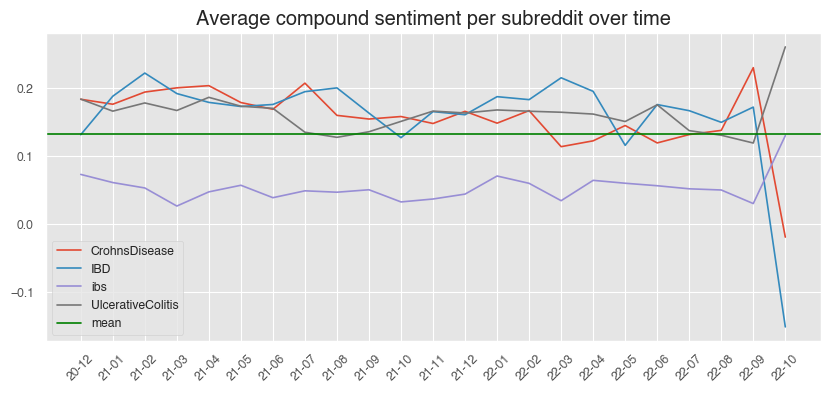

In [36]:
fig, ax = plt.subplots(figsize=(10,4))
plt.title('Average compound sentiment per subreddit over time')
sns.lineplot(x=df_crohns.groupby('created').count().compound.keys(), y=avg_sentiments_crohn, ax=ax, label='CrohnsDisease')
sns.lineplot(x=df_ibd.groupby('created').count().compound.keys(), y=avg_sentiments_ibd, ax=ax, label='IBD')
sns.lineplot(x=df_ibs.groupby('created').count().compound.keys(), y=avg_sentiments_ibs, ax=ax, label='ibs')
sns.lineplot(x=df_ulc.groupby('created').count().compound.keys(), y=avg_sentiments_ulc, ax=ax, label='UlcerativeColitis')
plt.xticks(rotation=45)
ax.set_xlabel('')
plt.axhline(mean([mean(avg_sentiments_crohn), mean(avg_sentiments_ibd), mean(avg_sentiments_ibs), mean(avg_sentiments_ulc)]), color='g', label='mean')

plt.legend()
plt.show();

In [112]:
cumulative_compounds = pd.DataFrame({
    'crohns_count': df_crohns.groupby('created').sum('compound').compound,
    'ibd_count': df_ibd.groupby('created').sum('compound').compound,
    'ibs_count': df_ibs.groupby('created').sum('compound').compound,
    'ulc_count': df_ulc.groupby('created').sum('compound').compound
})

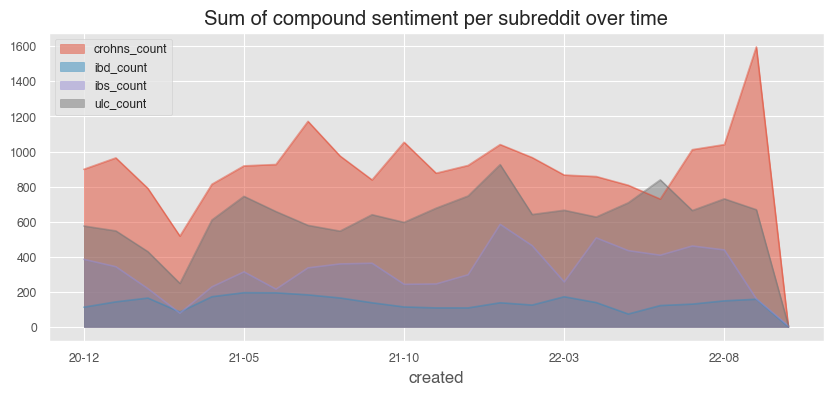

In [113]:
fig, ax = plt.subplots(figsize=(10,4))

cumulative_compounds.plot(kind='area', stacked=False, ax=ax)
ax.set_title('Sum of compound sentiment per subreddit over time')
plt.show();

### Sentiment Analysis on filtered data <a class='anchor' id='sentiment-filtered'></a>

In [39]:
covid_keywords = [
    "Pandemic",
    "pandemic",
    "coronavirus" ,
    "CORONAVIRUS",
    "Coronavirus",
    "COVID-19",
    "COVID19",
    "COVID",
    "COVID 19",
    "covid-19",
    "covid19",
    "covid",
    "cov",
    "covid 19",
    "Covid-19",
    "Covid19",
    "Covid",
    "Covid 19",
    "Vaccine",
    "vaccine"
    "SARS-COV-2",
    "SARS COV-2",
    "SARS-COV2",
    "SARS-COV 2",
    "SARS COV"
]

In [40]:
pattern = '|'.join([f'{keyword}' for keyword in covid_keywords])

In [41]:
df_filtered = df[df.title_and_body.str.contains(pattern)]

In [42]:
df_filtered.shape[0]

17165

In [43]:
df_filtered = df_filtered[['id', 'subreddit', 'author', 'title', 'body', 'title_and_body', 'score', 'num_comments', 'created', 'sia_vader', 'compound_vader', 'label_vader']]

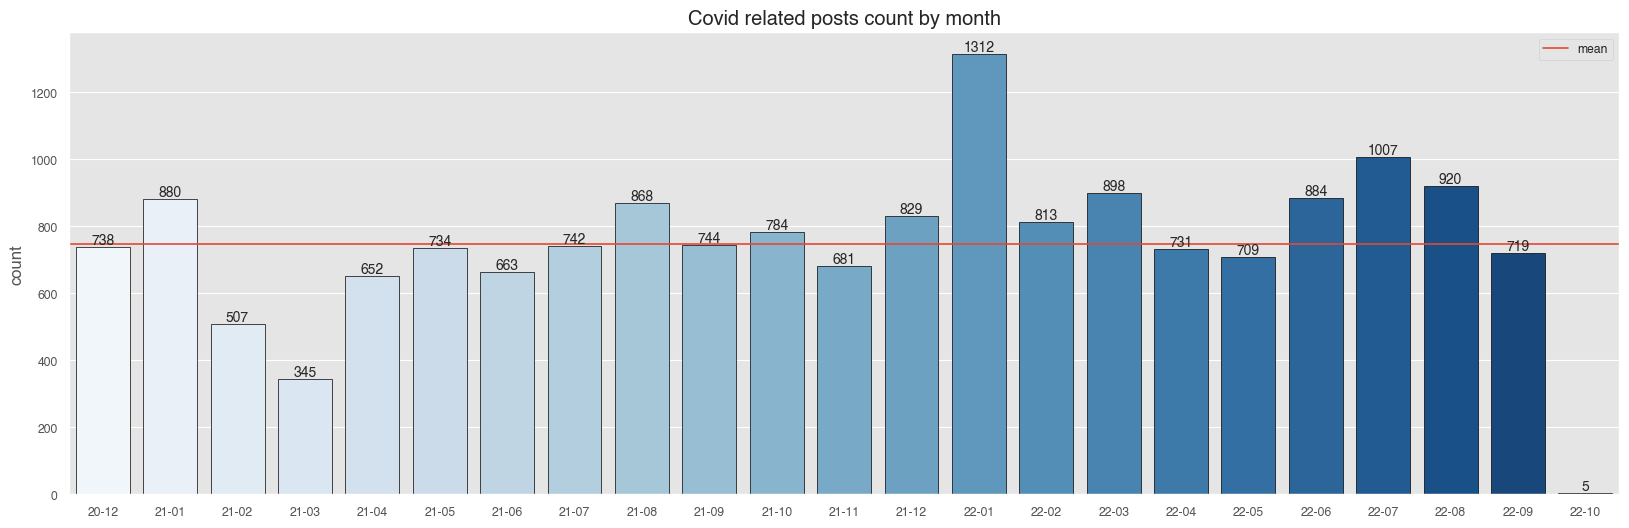

In [44]:
cov_counts_month = df_filtered['created'].dt.strftime('%y-%m').value_counts().sort_index().reset_index(name='counts')

plt.figure(figsize=(20,6))
ax = sns.barplot(x='index', y='counts', data=cov_counts_month, edgecolor='black', palette='Blues')
plt.title('Covid related posts count by month')
ax.bar_label(ax.containers[0])
plt.axhline(cov_counts_month.counts.mean(), label='mean')
plt.ylabel('count')
plt.xlabel('')

plt.legend()
plt.show()

#### Compound filtered data <a class='anchor' id='cov-comp'></a>

In [45]:
df_filtered.created = df_filtered.created.apply(lambda x : x.strftime('%y-%m'))

cov_sentiment_by_month = df_filtered.groupby('created').sum('compound').compound_vader.values
cov_number_of_posts_over_time = df_filtered.groupby('created').count().compound_vader.values
cov_avg_sentiments = []
for i in range(0, len(cov_sentiment_by_month)):
    cov_avg_sentiments.append(cov_sentiment_by_month[i] / cov_number_of_posts_over_time[i])

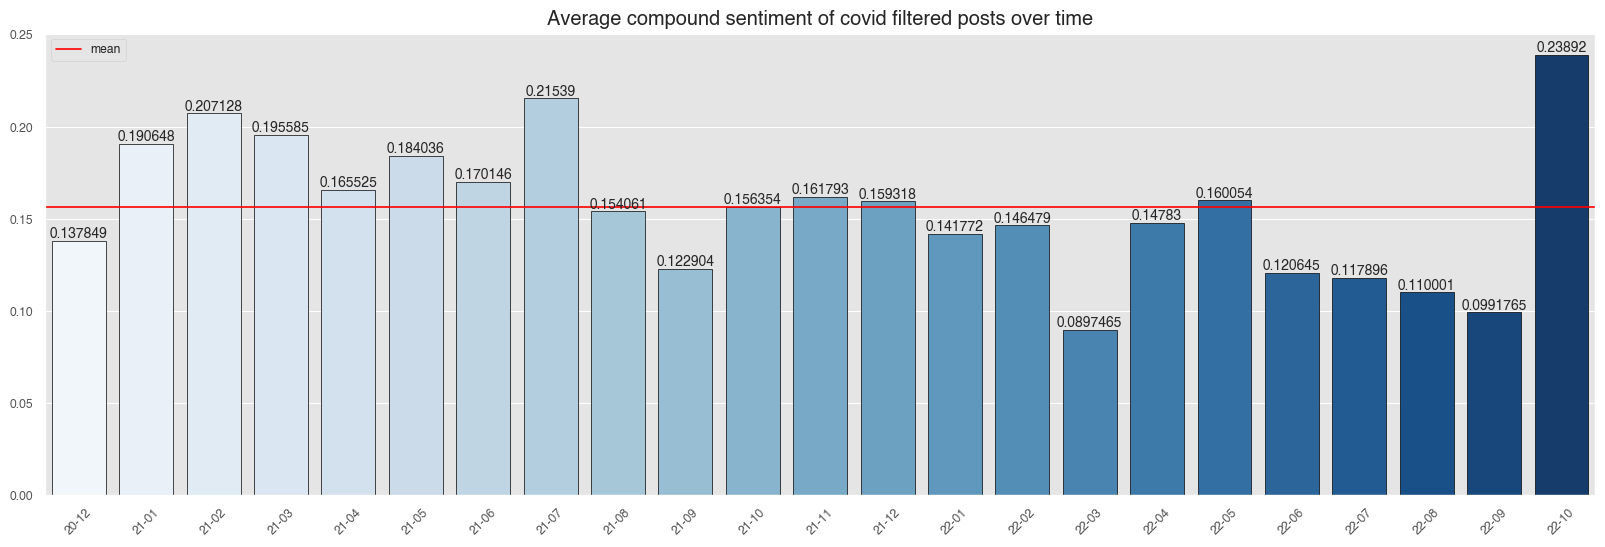

In [46]:
fig, ax = plt.subplots(figsize=(20,6))
plt.title('Average compound sentiment of covid filtered posts over time')
sns.barplot(x=df_filtered.groupby('created').count().compound_vader.keys(), y=cov_avg_sentiments, edgecolor='black', palette='Blues', ax=ax)
plt.xticks(rotation=45)
ax.set_xlabel('')
plt.axhline(mean(cov_avg_sentiments), color='r', label='mean')
ax.bar_label(ax.containers[0])

plt.legend(loc='upper left')
plt.show();

#### Positive and Negative rate of covid posts <a class='anchor' id='pos-neg-rates-cov'></a>

In [47]:
cov_pos_per_month = df_filtered[df_filtered['label_vader'] == 1].groupby('created').count().label_vader
cov_neg_per_month = df_filtered[df_filtered['label_vader'] == -1].groupby('created').count().label_vader
cov_number_of_posts_over_time = df_filtered.groupby('created').count().compound_vader.values

cov_pos_rate_per_month = []
cov_neg_rate_per_month = []
for i in range(len(pos_per_month)):
    cov_neg_rate_per_month.append(cov_neg_per_month[i] / cov_number_of_posts_over_time[i])
    cov_pos_rate_per_month.append(cov_pos_per_month[i] / cov_number_of_posts_over_time[i])
    
dates = df_filtered.groupby('created').count().compound_vader.keys()
df_cov_rates = pd.DataFrame({
    'pos_rate': cov_pos_rate_per_month,
    'neg_rate': cov_neg_rate_per_month,
    'date': dates
})

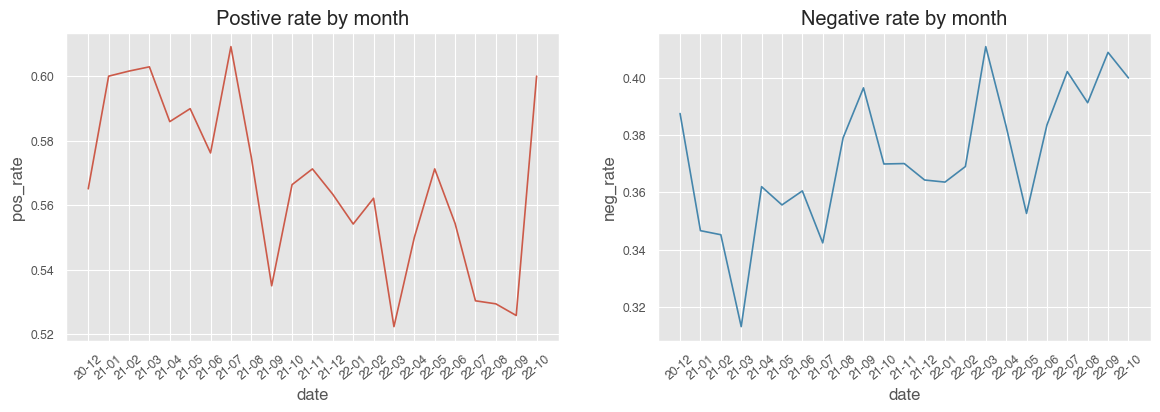

In [48]:
fig, [ax1, ax2] = plt.subplots(figsize=(14,4), ncols=2, nrows=1)

plt.setp(ax1.xaxis.get_majorticklabels(), rotation=40)
ax1.set_title('Postive rate by month')
sns.lineplot(x='date', y='pos_rate', data=df_cov_rates, ax=ax1, color=colors[0])

plt.setp(ax2.xaxis.get_majorticklabels(), rotation=40)

ax2.set_title('Negative rate by month')
sns.lineplot(x='date', y='neg_rate', data=df_cov_rates, ax=ax2, color=colors[1])

plt.show();

- The positive rate is for sure higher than the negative, but again after **July 2021** it started descending. 
- The negative rate starts ascending from **July 2021** with some down peeks

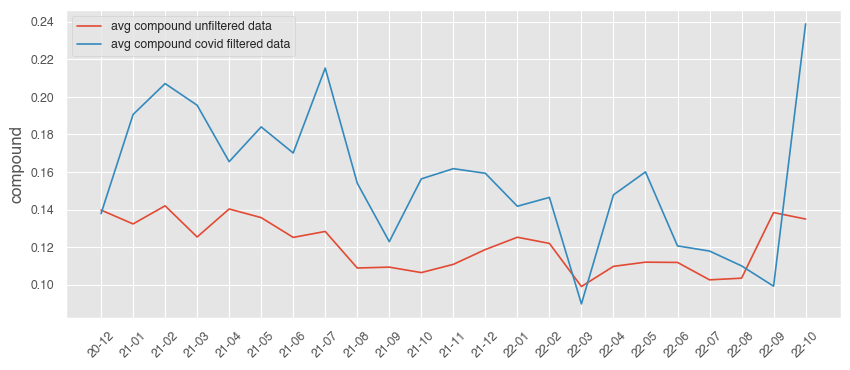

In [49]:
fig, ax = plt.subplots(figsize=(10,4))
sns.lineplot(x=df_vader.groupby('created').count().compound.keys(), y=avg_sentiments, ax=ax, label='avg compound unfiltered data')
sns.lineplot(x=df_filtered.groupby('created').count().compound_vader.keys(), y=cov_avg_sentiments, ax=ax, label='avg compound covid filtered data')
plt.xticks(rotation=45)
ax.set_xlabel('')
ax.set_ylabel('compound')
plt.show();

In [50]:
df_cov_subr = df_filtered[['label_vader', 'created', 'subreddit']]
df_cov_subr.rename(columns={'label_vader': 'label'}, inplace=True)

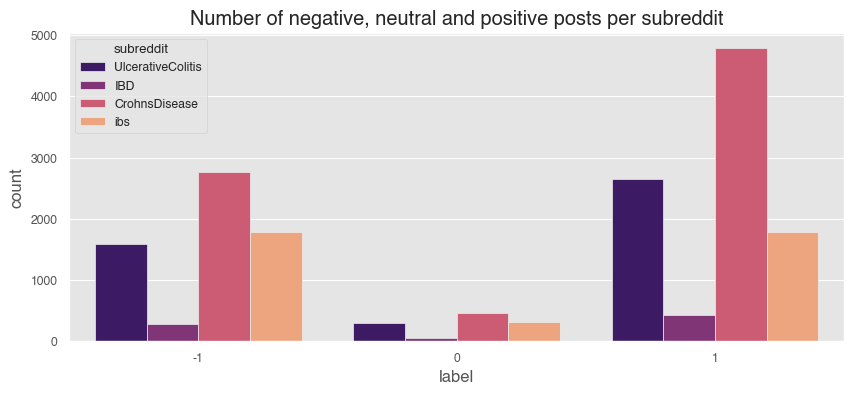

In [51]:
fig, ax = plt.subplots(figsize=(10,4))

sns.countplot(x='label', hue='subreddit', data=df_cov_subr, palette='magma')
plt.title('Number of negative, neutral and positive posts per subreddit')
plt.show();

In [52]:
cov_rates = []
for sr in subreddits:
    dd = df_cov_subr[df_cov_subr['subreddit'] == sr]
    dd_pos = dd[dd['label'] == 1]
    dd_neg = dd[dd['label'] == -1]
    dd_neu = dd[dd['label'] == 0]
    pos_rate = dd_pos.shape[0] / df_filtered[df_filtered['subreddit'] == sr].shape[0]
    neg_rate = dd_neg.shape[0] / df_filtered[df_filtered['subreddit'] == sr].shape[0]
    neu_rate = dd_neu.shape[0] / df_filtered[df_filtered['subreddit'] == sr].shape[0]
    
    cov_rates.append((pos_rate, sr, 1))
    cov_rates.append((neg_rate, sr, -1))
    cov_rates.append((neu_rate, sr, 0))
    
cov_rates = pd.DataFrame(cov_rates, columns=['rate', 'subreddit', 'label'])

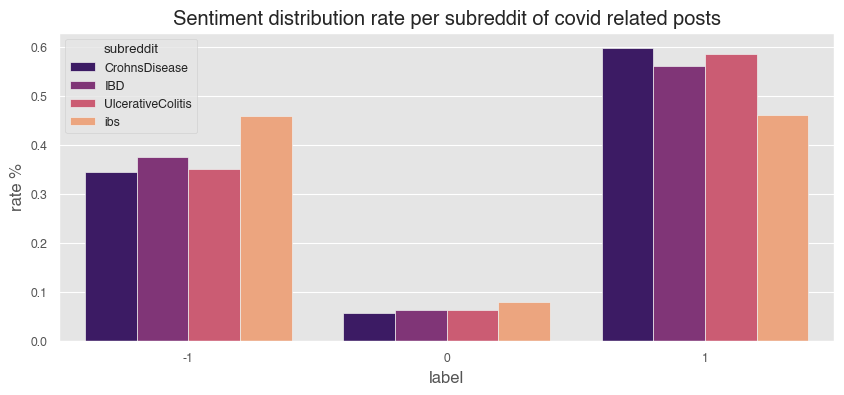

In [53]:
fig, ax = plt.subplots(figsize=(10,4))

sns.barplot(data=cov_rates, x='label', y='rate', hue='subreddit', palette='magma', ax=ax)
plt.title('Sentiment distribution rate per subreddit of covid related posts')
ax.set_ylabel('rate %')
plt.show();

In [54]:
df_pos_vs_neg_vad = df_filtered[['label_vader', 'created']]
df_pos_vs_neg_vad.columns = ['label', 'created']

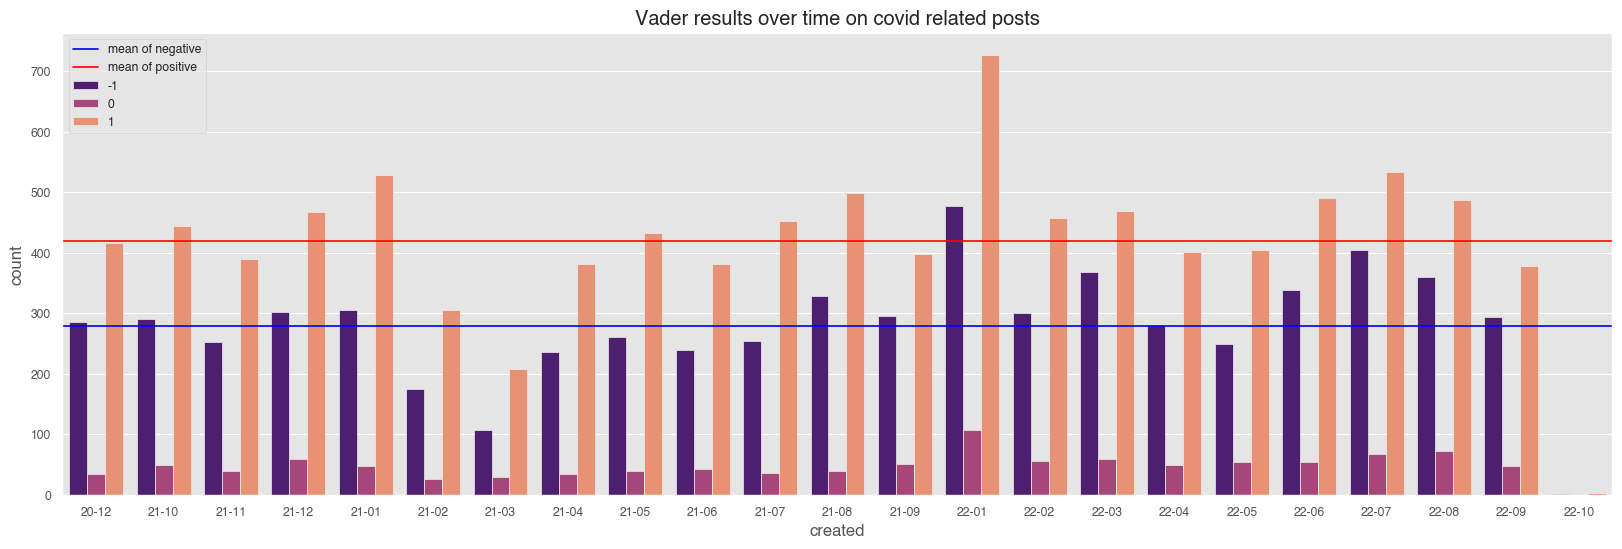

In [55]:
fig, ax = plt.subplots(figsize=(20,6))

sns.countplot(x='created', hue='label', data=df_pos_vs_neg_vad, palette='magma')
plt.axhline(mean(df_pos_vs_neg_vad[df_pos_vs_neg_vad['label'] == -1].groupby('created').count().label), 
            label='mean of negative', color='blue')
plt.axhline(mean(df_pos_vs_neg_vad[df_pos_vs_neg_vad['label'] == 1].groupby('created').count().label), 
            label='mean of positive', color='red')
plt.title('Vader results over time on covid related posts')

plt.legend(loc='upper left')
plt.show();

# Difference between subreddit

In [56]:
df1 = pd.DataFrame({
    'compound': avg_sentiments,
    'date': df.created.apply(lambda x: x.strftime('%y-%m')).unique(),
    'label': 'unfiltered'
})

df2 = pd.DataFrame({
    'compound': cov_avg_sentiments,
    'date': df.created.apply(lambda x: x.strftime('%y-%m')).unique(),
    'label': 'filtered'
})

df_result = pd.concat([df1, df2], ignore_index=True)

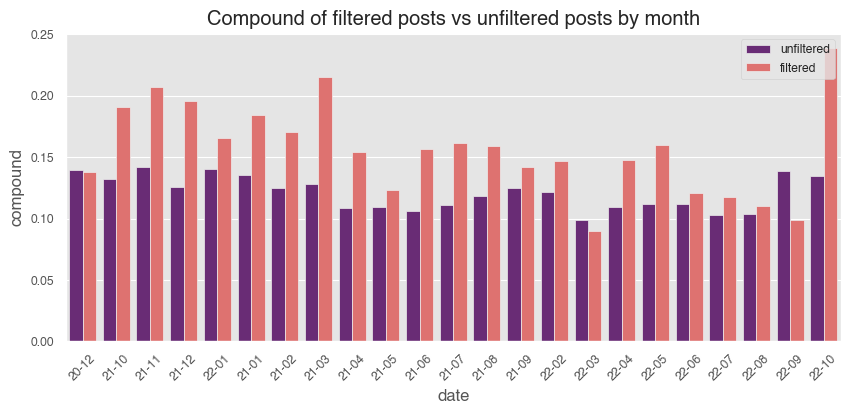

In [57]:
fig, ax = plt.subplots(figsize=(10,4))

sns.barplot(data=df_result, x='date', y='compound', hue='label', palette='magma', ax=ax)
plt.title('Compound of filtered posts vs unfiltered posts by month')
ax.set_ylabel('compound')
plt.xticks(rotation=45)
plt.legend(loc='upper right')
plt.show();

Concluding the analysis with vader the results seems to be not relevant, because the positives post are so much more than the negatives.  


There may be several reason for these, one to consider is that vader is built and trained for short sentences while data from reddit tend to be long and complicated texts. 

Two things to consider for sure are the results prodcued by [compound of filtered data plot](#cov-comp) and [positives vs negatives rates of covid posts](#pos-neg-rates-cov).  

To deepen the topic it'll be introduced another model called **roBERTa**

### Introducing roBERTa <a class='anchor' id='roberta'></a>

In [58]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax

In [59]:
roberta = "cardiffnlp/twitter-roberta-base-sentiment"

model = AutoModelForSequenceClassification.from_pretrained(roberta)
tokenizer = AutoTokenizer.from_pretrained(roberta)
labels = ['neg', 'neu', 'pos']

In [60]:
sentiments = []
all_sentiments = []
for post in tqdm(df_filtered.title_and_body, desc='Analyzing with roBERTa'):
    encoded_post = tokenizer(post, return_tensors='pt', max_length=256, truncation=True)
    output = model(**encoded_post)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    sentiments.append(labels[np.argmax(scores)])
    
    ranking = np.argsort(scores)
    ranking = ranking[::-1]
    dict_rob = {}
    for i in range(scores.shape[0]):
        l = labels[ranking[i]]
        s = scores[ranking[i]]
        dict_rob[l] = np.round(float(s), 4)
        
    all_sentiments.append(dict_rob)

Analyzing with roBERTa:   0%|          | 0/17165 [00:00<?, ?it/s]

In [61]:
def convert_label(text):
    if text == 'pos':
        return 1
    elif text == 'neg':
        return -1
    else:
        return 0
    
sentiments_roberta = map(convert_label, sentiments)
sentiments_roberta = list(sentiments_roberta)

df_filtered['roberta'] = all_sentiments
df_filtered['label_roberta'] = sentiments_roberta

In [62]:
rob = df_filtered[['label_roberta']]
rob['model'] = 'roberta'

vad = df_filtered[['label_vader']]
vad['model'] = 'vader'

vad.columns = ['label', 'model']
rob.columns = ['label', 'model']

rob_vs_vad = pd.concat([rob, vad], ignore_index=True)

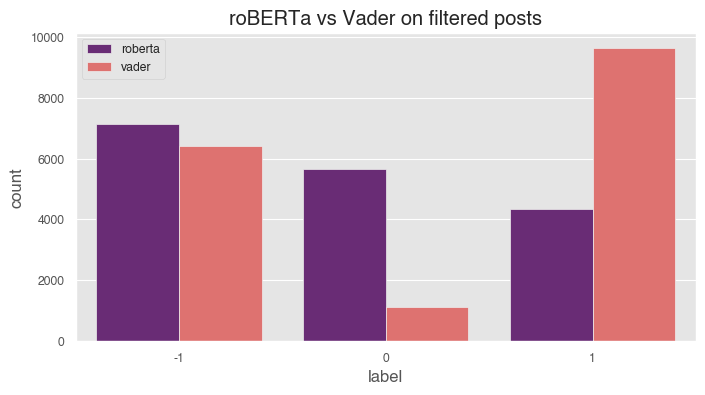

In [63]:
fig, ax = plt.subplots(figsize=(8,4))

sns.countplot(data=rob_vs_vad, x='label', hue='model', palette='magma', ax=ax)
plt.title('roBERTa vs Vader on filtered posts')
ax.set_ylabel('count')
plt.legend(loc='upper left')
plt.show();

Comparing **vader** and **roBERTa** it's clear that roBERTa label much more **neutral** values

In [64]:
vader_neg = []
vader_pos = []
vader_neu = []
roberta_neg = []
roberta_pos = []
roberta_neu = []
for entry in df_filtered.sia_vader:
    vader_neg.append(entry['neg'])
    vader_pos.append(entry['pos'])
    vader_neu.append(entry['neu'])
    
for entry in df_filtered.roberta:
    roberta_pos.append(entry['pos'])
    roberta_neg.append(entry['neg'])
    roberta_neu.append(entry['neu'])

In [65]:
labels = np.array(df_filtered[['label_vader']])

In [66]:
df_compare_vader_rob = pd.DataFrame({
    'roberta_neg': roberta_neg,
    'vader_neg': vader_neg,
    'roberta_pos': roberta_pos,
    'vader_pos': vader_pos,
    'roberta_neu': roberta_neu,
    'vader_neu': vader_neu,
})

df_compare_vader_rob['label_vader'] = labels

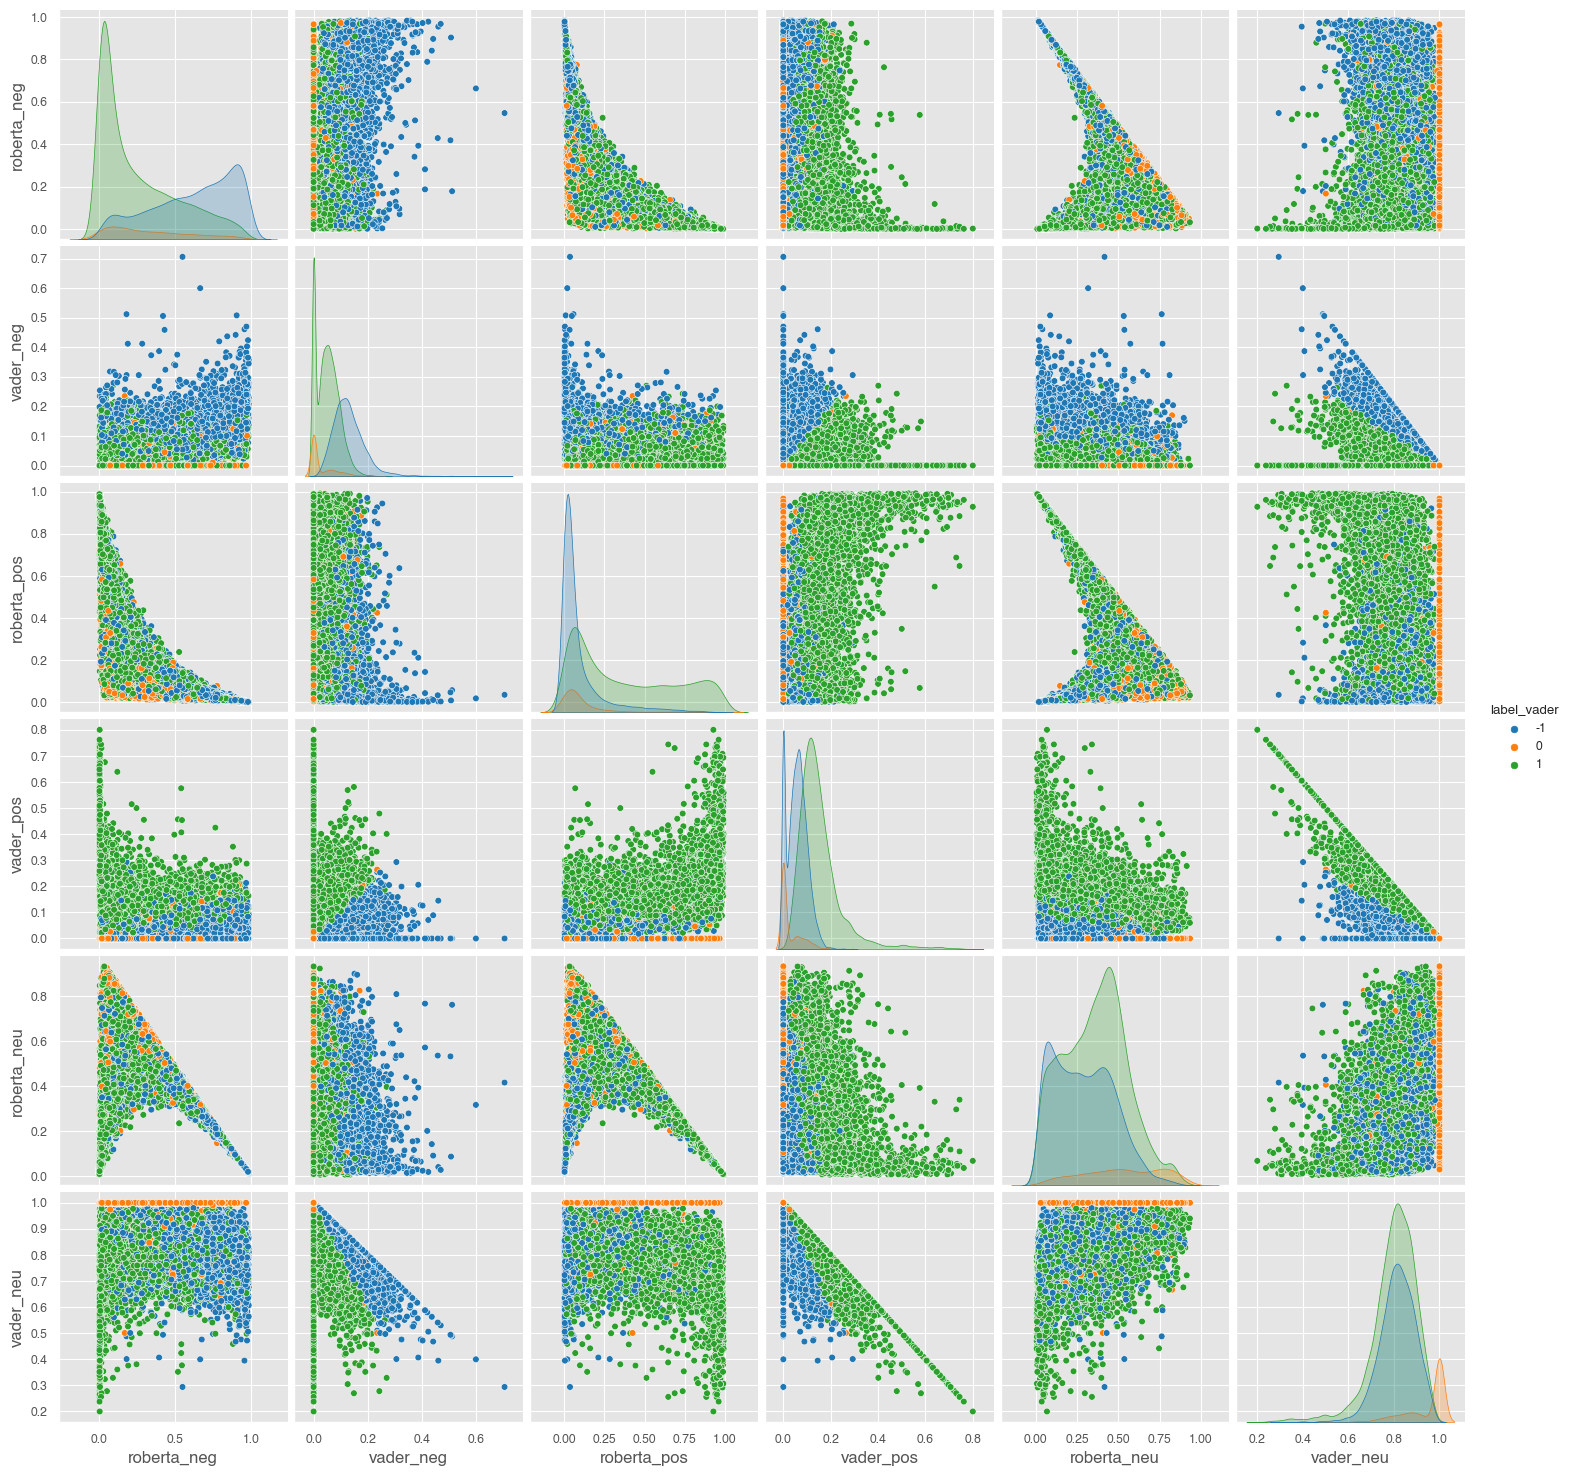

In [67]:
sns.pairplot(df_compare_vader_rob, 
             hue='label_vader', 
             diag_kind='kde',
             palette='tab10')

plt.show();

In [68]:
df_pos_vs_neg_rob = df_filtered[['label_roberta', 'created', 'subreddit']]
df_pos_vs_neg_rob.rename(columns={'label_roberta': 'label'}, inplace=True)

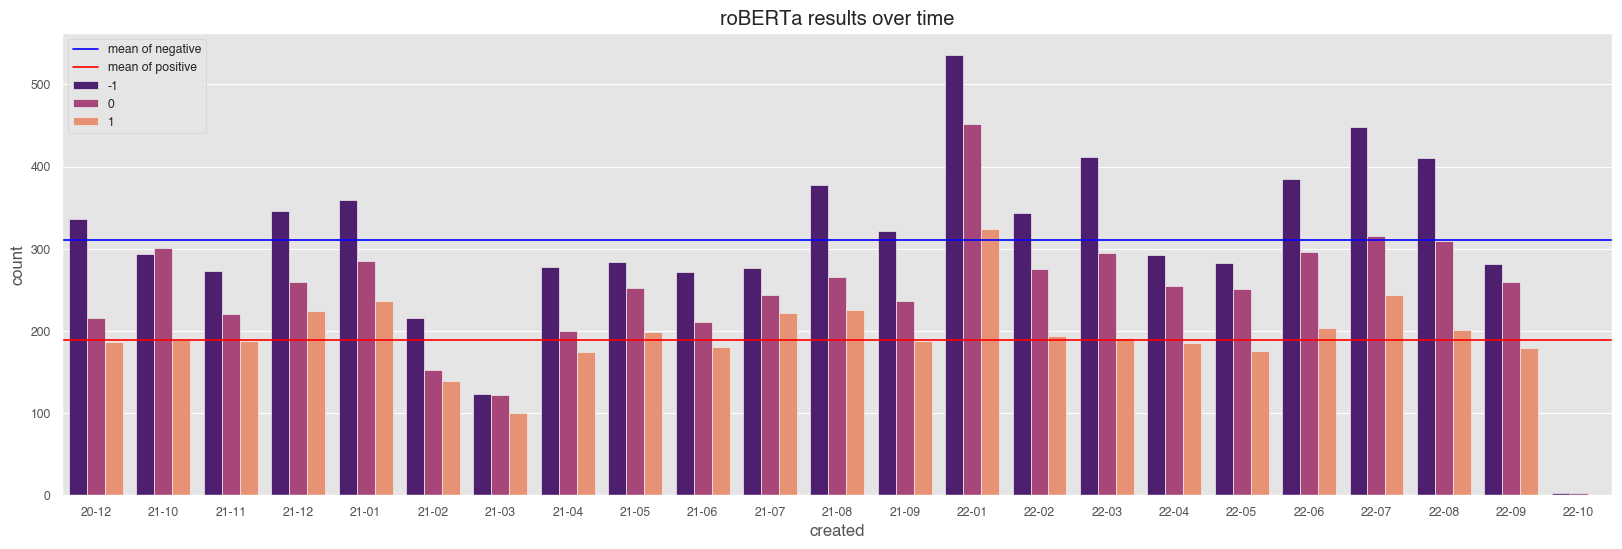

In [69]:
fig, ax = plt.subplots(figsize=(20,6))

sns.countplot(x='created', hue='label', data=df_pos_vs_neg_rob, palette='magma')
plt.axhline(mean(df_pos_vs_neg_rob[df_pos_vs_neg_rob['label'] == -1].groupby('created').count().label), 
            label='mean of negative', color='blue')
plt.axhline(mean(df_pos_vs_neg_rob[df_pos_vs_neg_rob['label'] == 1].groupby('created').count().label), 
            label='mean of positive', color='red')
plt.title('roBERTa results over time')

plt.legend(loc='upper left')
plt.show();

### When do roBERTa and Vader get on ? <a class='anchor' id='vader-geton-rob'><a/>

In [70]:
df_final = df_filtered[df_filtered['label_roberta'] == df_filtered['label_vader']]
df_final.drop(columns=['label_vader'], inplace=True)
df_final.rename(columns={'label_roberta': 'label'}, inplace=True)

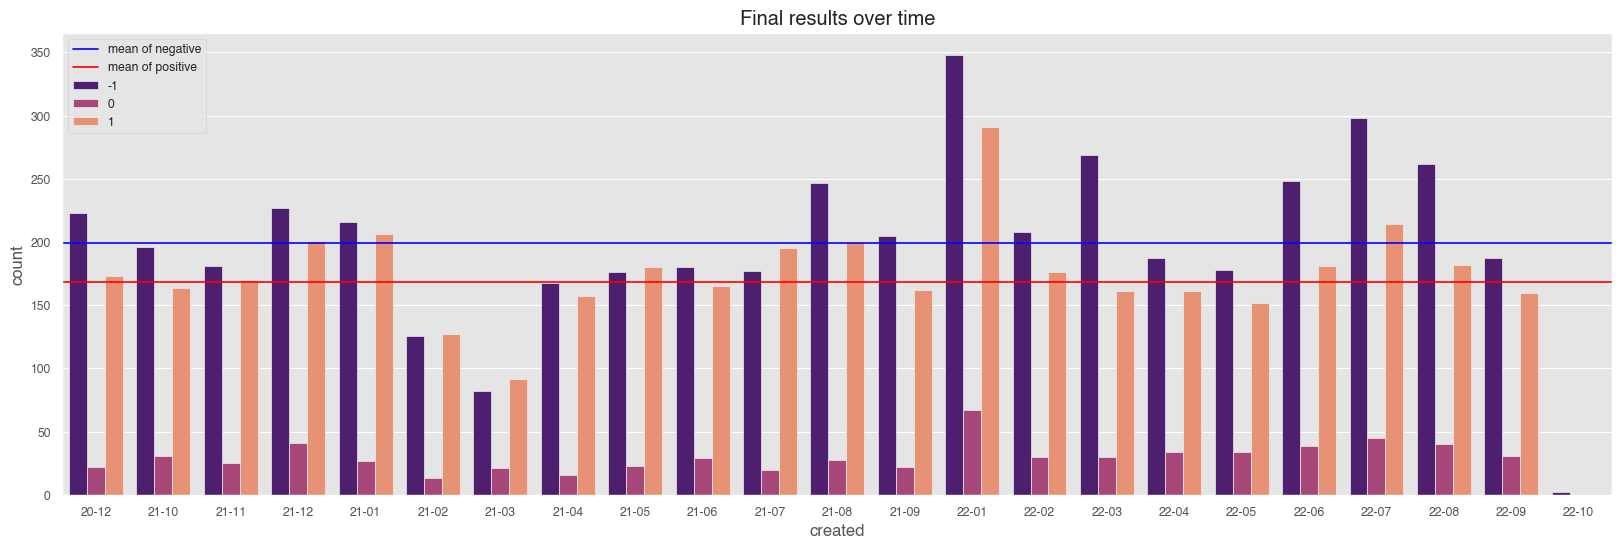

In [71]:
df_pos_vs_neg_final = df_final[['label', 'created', 'subreddit']]

fig, ax = plt.subplots(figsize=(20,6))

sns.countplot(x='created', hue='label', data=df_pos_vs_neg_final, palette='magma')
plt.axhline(mean(df_pos_vs_neg_final[df_pos_vs_neg_final['label'] == -1].groupby('created').count().label), 
            label='mean of negative', color='blue')
plt.axhline(mean(df_pos_vs_neg_final[df_pos_vs_neg_final['label'] == 1].groupby('created').count().label), 
            label='mean of positive', color='red')
plt.title('Final results over time')

plt.legend(loc='upper left')
plt.show();

The plot above shows the count of positive, negative and neutral data over time.  
Data shown are those who are equal labelled by vader and roBERTa.

### Frequency Distribution <a class='anchor' id='freq-dist'><a/>

In [72]:
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk import FreqDist 

import nltk
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

#nltk.download('wordnet')
#nltk.download('omw-1.4')
#nltk.download('shakespeare')
#nltk.download('stopwords')

stopwords = nltk.corpus.stopwords.words("english")

# tfidf

In [73]:
# Tokenize
def tokenize(data):
    tokenizer = RegexpTokenizer('\w+|\$[\d\.]+http\S+')
    data['tokenized'] = data['title_and_body'].apply(lambda x: tokenizer.tokenize(x))
    return data

In [74]:
# Remove stopwords 
def remove_sw(data):
    data['token_without_sw'] = data['tokenized'].apply(lambda x: [word for word in x if not word in stopwords and len(word) > 2 and not word in ["www", "http", "https", "reddit", "cricket", "nan"]])
    return data

In [78]:
%%capture

tokenize(df_filtered)
remove_sw(df_filtered)

In [80]:
all_words = " ".join(x for x in df_filtered['token_without_sw'].apply(lambda x: " ".join(x))).split(" ")
fd = nltk.FreqDist([w.lower() for w in all_words])

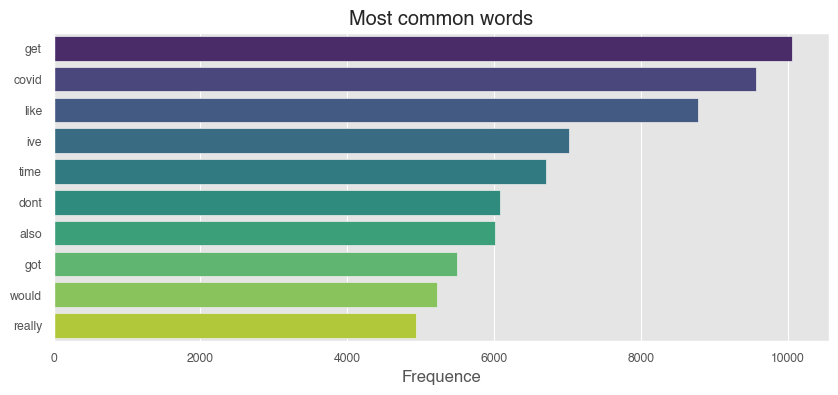

In [81]:
# Most common words
common_freq = dict(fd.most_common(10))
common_freq = pd.Series(common_freq)

fig, ax = plt.subplots(figsize=(10,4))

# Plot 1
ax.set_title('Most common words')
sns.barplot(y=common_freq.index, x=common_freq, orient='h', ax=ax, palette='viridis')
ax.set_xlabel('Frequence')

plt.show();

### Concordances and Quadgrams <a class='anchor' id='conc-quad'></a>

- In the context of NLP, a concordance is a collection of word locations along with their context.

- Quadgrams are four words combinations 

In [82]:
all_words = " ".join(x for x in df_filtered['tokenized'].apply(lambda x: " ".join(x))).split(" ")
text = nltk.Text(all_words)

In [83]:
print(colored('\nSOME CONCORDANCES\n', color='blue'))
doctor_conc = text.concordance('doctor', lines=5)
print('\n')
covid_conc = text.concordance('covid', lines=5)
print('\n')
worse_conc = text.concordance('worse', lines=10)
print('\n')
getting_conc = text.concordance('getting', lines=5)
print('\n')
vaccine_conc = text.concordance('vaccine', lines=5)


SOME CONCORDANCES

Displaying 5 of 3701 matches:
a of how long i have to wait for my doctor to receive approval for me to use e
ely as well but have a bit to go my doctor says the medicine i am on may actua
to no quality of life thankfully my doctor was able to move my j pouch appoint
ntense pain that the hydrocodone my doctor prescribed me doing little to nothi
e er wasnt busy but i never saw the doctor i only met with the nurses who came


Displaying 5 of 9569 matches:
ermometer i even tested negative for covid which i took just to be cautious im 
 many times its good that because of covid i am allowed to wfh but when covid e
f covid i am allowed to wfh but when covid ends i dont think i will be able to 
am sure i wont be having a job after covid half of my time is spent me sitting 
 have you took any blood thinner for covid if yes which one it really just hit 


Displaying 10 of 1945 matches:
year because my condition is getting worse and i would like a second opinion ho
s 17cm up 

In [84]:
quadgram = nltk.collocations.QuadgramCollocationFinder.from_words(all_words)
quadgram.ngram_fd.most_common(20)

[(('i', 'was', 'diagnosed', 'with'), 278),
 (('i', 'was', 'able', 'to'), 258),
 (('to', 'go', 'to', 'the'), 253),
 (('i', 'dont', 'want', 'to'), 230),
 (('for', 'the', 'first', 'time'), 193),
 (('i', 'went', 'to', 'the'), 191),
 (('at', 'the', 'same', 'time'), 178),
 (('i', 'dont', 'know', 'if'), 172),
 (('at', 'the', 'end', 'of'), 166),
 (('i', 'was', 'in', 'the'), 159),
 (('i', 'dont', 'know', 'what'), 154),
 (('a', 'lot', 'of', 'people'), 154),
 (('in', 'the', 'middle', 'of'), 151),
 (('the', 'end', 'of', 'the'), 148),
 (('go', 'to', 'the', 'bathroom'), 142),
 (('you', 'a', 'speedy', 'recovery'), 141),
 (('to', 'be', 'able', 'to'), 137),
 (('i', 'just', 'want', 'to'), 129),
 (('tested', 'positive', 'for', 'covid'), 129),
 (('i', 'feel', 'like', 'i'), 119)]

### Wordclouds <a class='anchor' id='wordcloud'></a>

In [85]:
from wordcloud import WordCloud, STOPWORDS

In [86]:
cov_pos = " ".join(sentiment for sentiment in df_final[df_final['label'] == 1]['title_and_body'])
cov_neg = " ".join(sentiment for sentiment in df_final[df_final['label'] == -1]['title_and_body'])

In [87]:
wc_cov_final_pos = WordCloud(width=2000,
                stopwords=stopwords,
                height=1600,
                max_font_size=500,
                max_words=50,
                collocations=False,
                background_color='black').generate(cov_pos)

wc_cov_final_neg = WordCloud(width=2000,
                stopwords=stopwords,
                height=1600,
                max_font_size=500,
                max_words=50,
                collocations=False,
                background_color='black').generate(cov_neg)

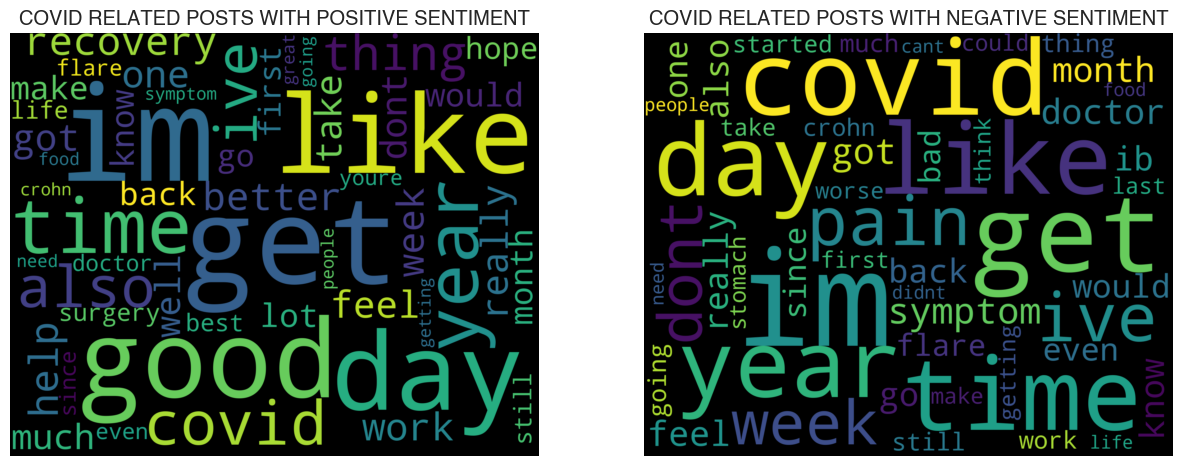

In [88]:
fig, ax = plt.subplots(figsize=(15,8), ncols=2, nrows=1)

ax[0].imshow(wc_cov_final_pos, interpolation="bilinear")
ax[0].axis('off')
ax[0].set_title('COVID RELATED POSTS WITH POSITIVE SENTIMENT')

ax[1].imshow(wc_cov_final_neg, interpolation="bilinear")
ax[1].axis('off')
ax[1].set_title('COVID RELATED POSTS WITH NEGATIVE SENTIMENT')

plt.show();

#### When compound sentiments was lower was the number of covid posts higher?

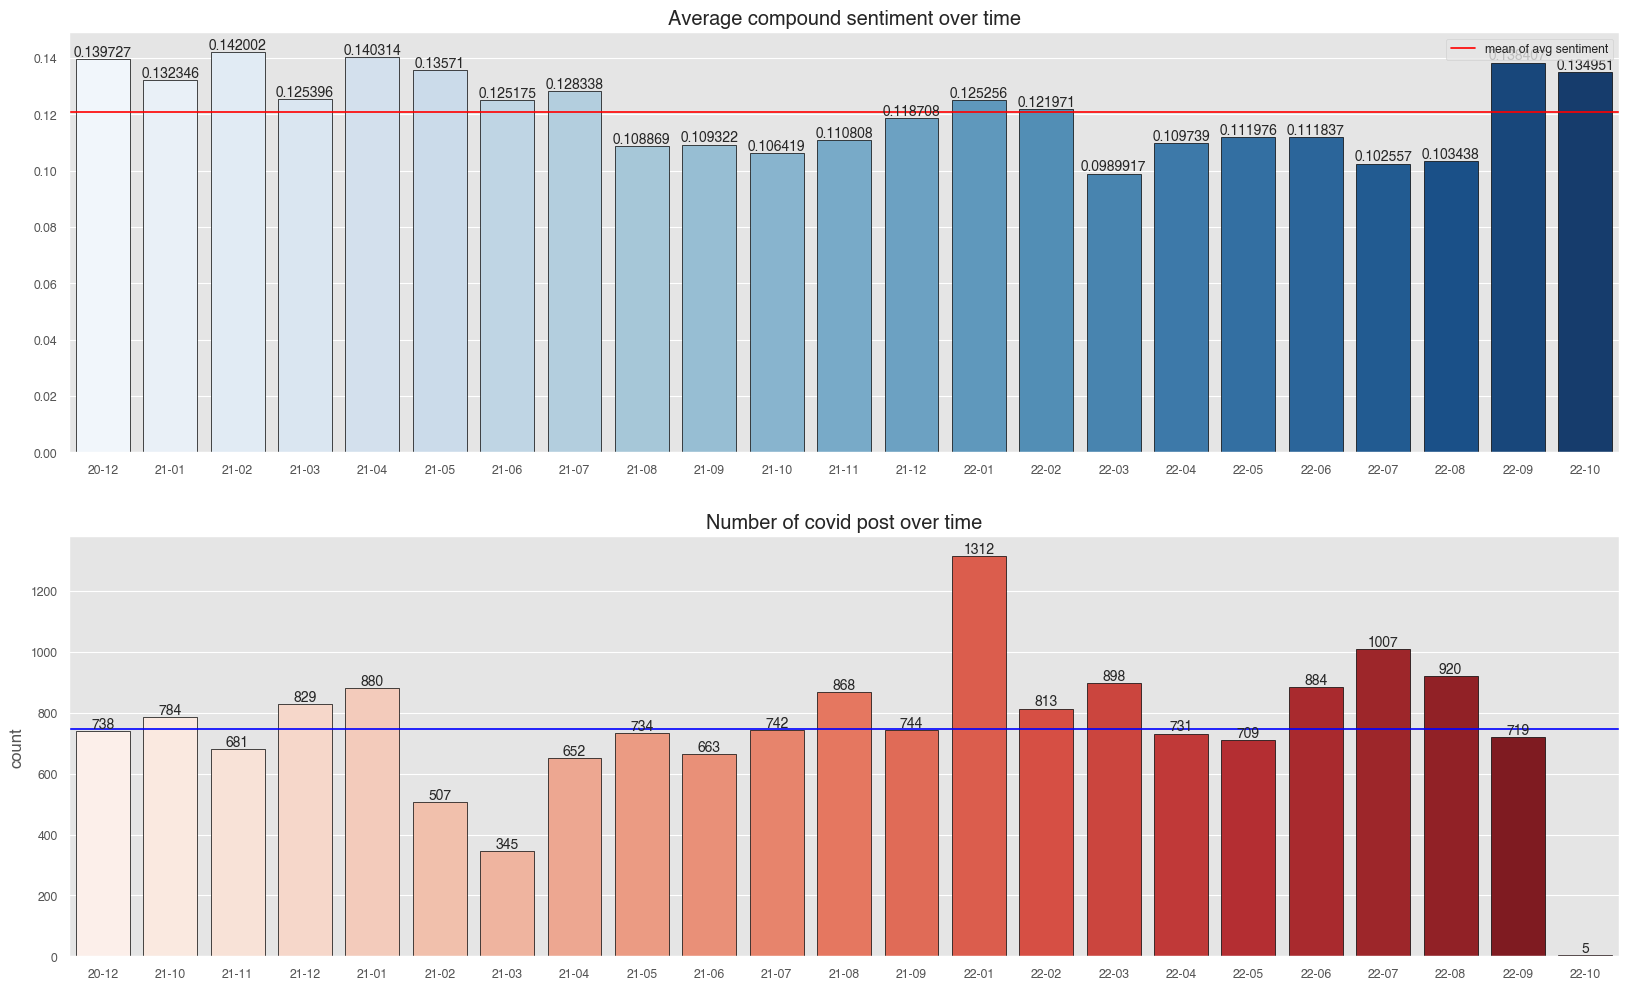

In [89]:
fig, [ax1, ax2] = plt.subplots(figsize=(20,12), ncols=1, nrows=2)
ax1.set_title('Average compound sentiment over time')
sns.barplot(x=df_vader.groupby('created').count().compound.keys(), y=avg_sentiments, edgecolor='black', palette='Blues', ax=ax1)
ax1.set_xlabel('')
mean_of_avg_sen = ax1.axhline(mean(avg_sentiments), color='r')
mean_of_avg_sen.set_label('mean of avg sentiment')
ax1.bar_label(ax1.containers[0])
ax1.legend(loc='best')

ax2.set_title('Number of covid post over time')
sns.countplot(x='created', edgecolor='black', palette='Reds', ax=ax2, data=df_filtered)
mean_of_covid_posts = ax2.axhline(mean(df_filtered.groupby('created').label_vader.count()), color='b')
mean_of_covid_posts.set_label('mean of covid posts')
ax2.set_xlabel('')
ax2.bar_label(ax2.containers[0])

plt.show();

In the last months, from **March 2022** to **August 2022** the compound sentiment of the posts stays always below the average. In the corresponding periods the covid related post count is above the average, and close to it for **April 2022** and **May 2022**

### RegExr specific filtering <a class='anchor' id='reg-filter'></a>

Last thing we can do is to analyze the correlation between covid and ibd diseases observing some of the texts that contains both keyterms.  

In [90]:
disease_keywords = [
    'crohn',
    'ibd',
    'ibs',
    'ulcerative',
    'colitis',
]

patterns = []
for k in covid_keywords:
    for dk in disease_keywords:
        s1 = f'{dk}.*{k}'
        s2 = f'{k}.*{dk}'
        patterns.append(s1)
        patterns.append(s2)

In [91]:
reg_expr = '|'.join([f'{p}' for p in patterns])

reg_df = df[df.title_and_body.str.contains(reg_expr)]

reg_df.created = reg_df.created.apply(lambda x: x.strftime('%y-%m'))

In [92]:
reg_df.shape[0]

5383

In [93]:
reg_sentiment_by_month = reg_df.groupby('created').sum('compound').compound_vader.values
reg_number_of_posts_over_time = reg_df.groupby('created').count().compound_vader.values
reg_avg_sentiments = []
for i in range(0, len(reg_sentiment_by_month)):
    reg_avg_sentiments.append(reg_sentiment_by_month[i] / reg_number_of_posts_over_time[i])

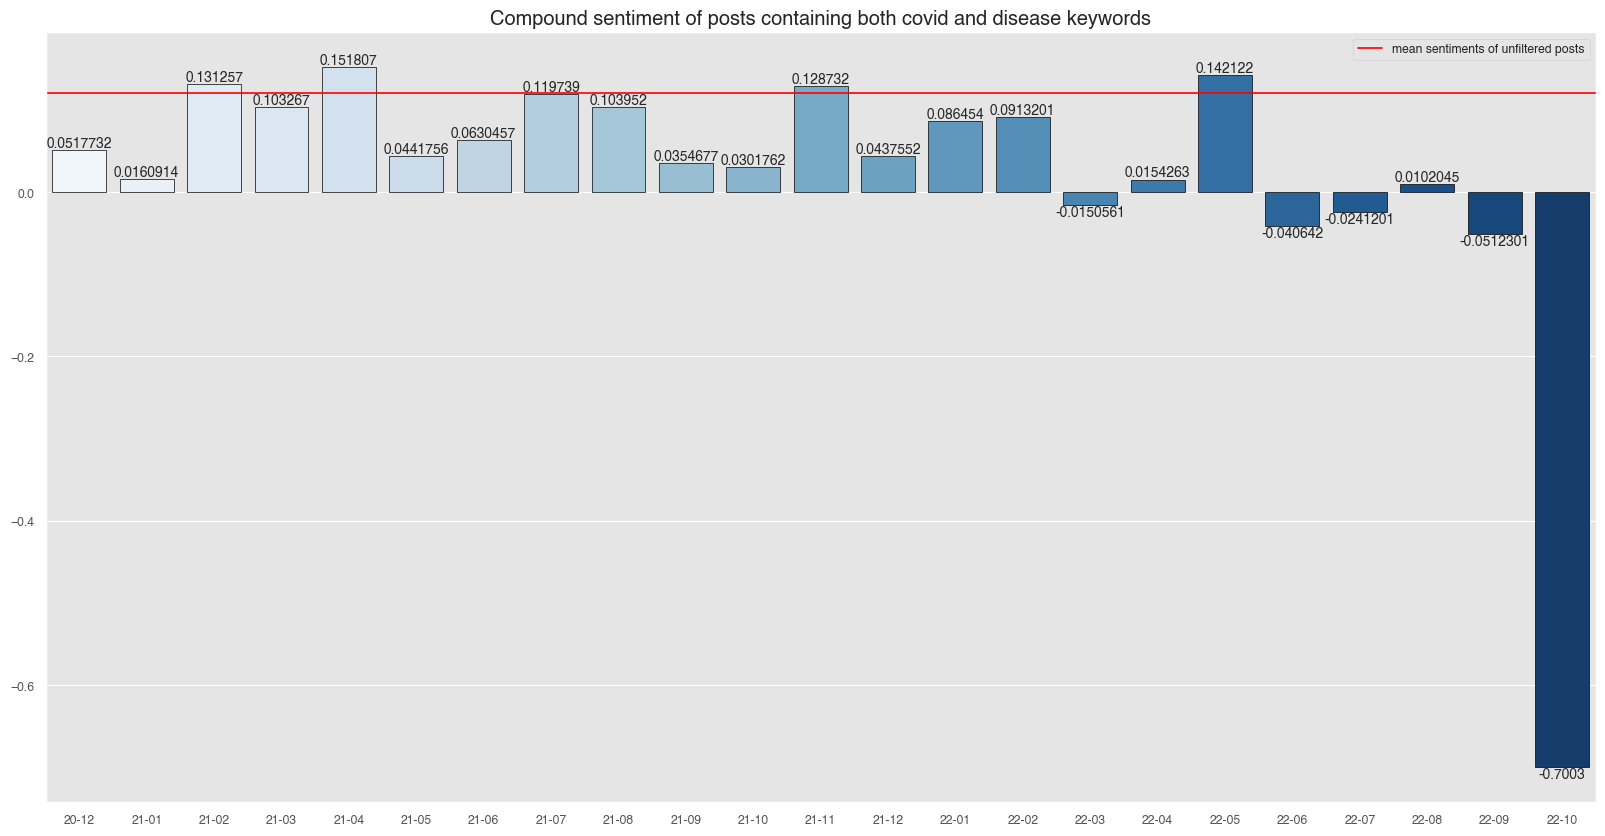

In [94]:
fig, ax1 = plt.subplots(figsize=(20,10), ncols=1, nrows=1)
ax1.set_title('Compound sentiment of posts containing both covid and disease keywords')
sns.barplot(x=reg_df.groupby('created').count().compound_vader.keys(), y=reg_avg_sentiments, edgecolor='black', palette='Blues', ax=ax1)
ax1.set_xlabel('')
ax1.bar_label(ax1.containers[0])
ax1.axhline(mean(avg_sentiments), color='r', label='mean sentiments of unfiltered posts')

plt.legend()
plt.show();

During March 2022 **World Health Organization** published [this paper](https://www.who.int/publications/m/item/weekly-epidemiological-update-on-covid-19---22-march-2022) which is mainly about the spread of omicron variant.

As **Yale Medicine** states [here](https://www.yalemedicine.org/news/covid-19-variants-of-concern-omicron) the omicron variant do not lead to many hospitalization but has one of the highest spread capacity.  

In [95]:
reg_sentiments = []
reg_all_sentiments = []
reg_labels = ['neg', 'neu', 'pos']
for post in tqdm(reg_df.title_and_body, desc='Analyzing with roBERTa'):
    encoded_post = tokenizer(post, return_tensors='pt', max_length=256, truncation=True)
    output = model(**encoded_post)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    reg_sentiments.append(labels[np.argmax(scores)])
    
    ranking = np.argsort(scores)
    ranking = ranking[::-1]
    dict_rob = {}
    for i in range(scores.shape[0]):
        l = reg_labels[ranking[i]]
        s = scores[ranking[i]]
        dict_rob[l] = np.round(float(s), 4)
        
    reg_all_sentiments.append(dict_rob)

Analyzing with roBERTa:   0%|          | 0/5383 [00:00<?, ?it/s]

In [96]:
reg_labels = []
for lab in reg_sentiments:
    reg_labels.append(lab[0])

reg_df['label_roberta'] = reg_labels

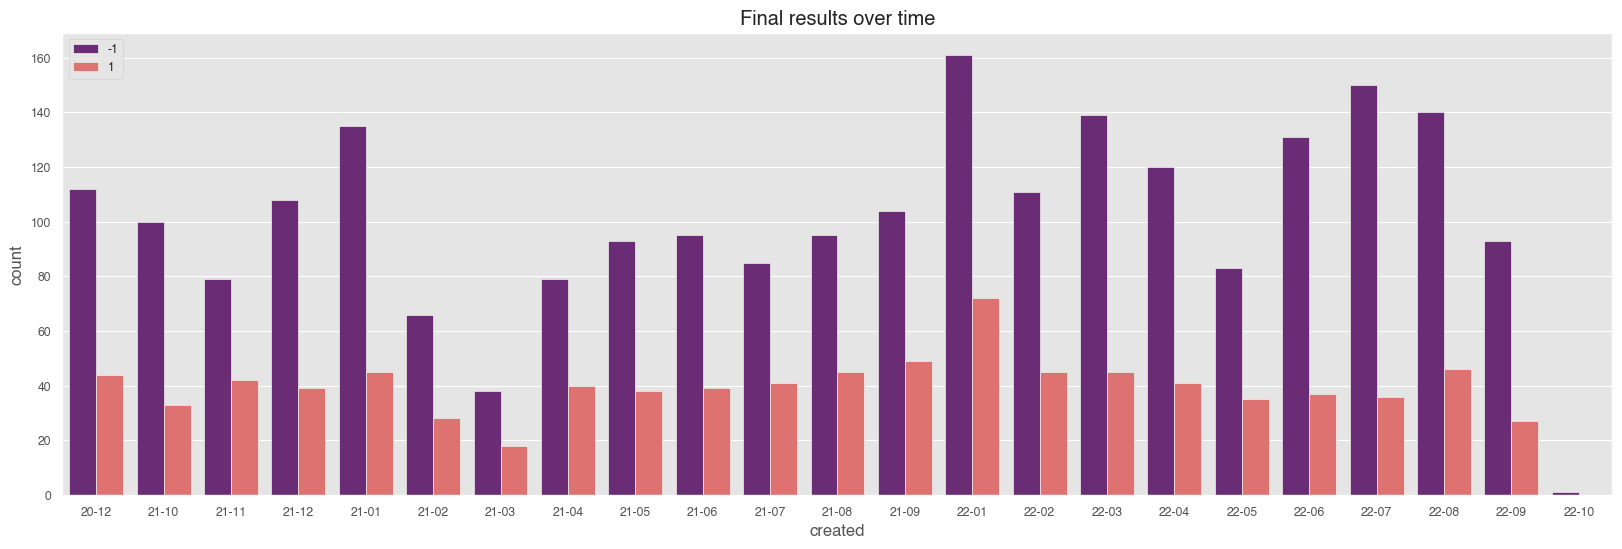

In [97]:
reg_vad_and_rob_df = reg_df[reg_df['label_vader'] == reg_df['label_roberta']]
fig, ax = plt.subplots(figsize=(20,6))

sns.countplot(x='created', hue='label_roberta', data=reg_vad_and_rob_df, palette='magma')
plt.title('Final results over time')

plt.legend(loc='upper left')
plt.show();

With specific filtering stands out that the negative posts per month are much more than the postives.  

Considering that the subreddit are about a disease the expectation is that the majority of the posts has negative trait, but a lot of the posts are about *healing*, *advices* and *knowledge share*. 
For this reason the average sentiment is not that low but the study shows that isolating posts about covid and then posts about ibd disease including covid keywords (so not covid keywords alone) are evaluated negatively by the algorithms.  

For this very last plot the results of both vader and roberta have been combined again.

In [98]:
fare_df = reg_df[reg_df['label_vader'] == reg_df['label_roberta']]

sent_by_month = fare_df.groupby('created').sum('compound').compound_vader.values
num_post_ot = fare_df.groupby('created').count().compound_vader.values
avg_sen = []
for i in range(0, len(sent_by_month)):
    avg_sen.append(sent_by_month[i] / num_post_ot[i])

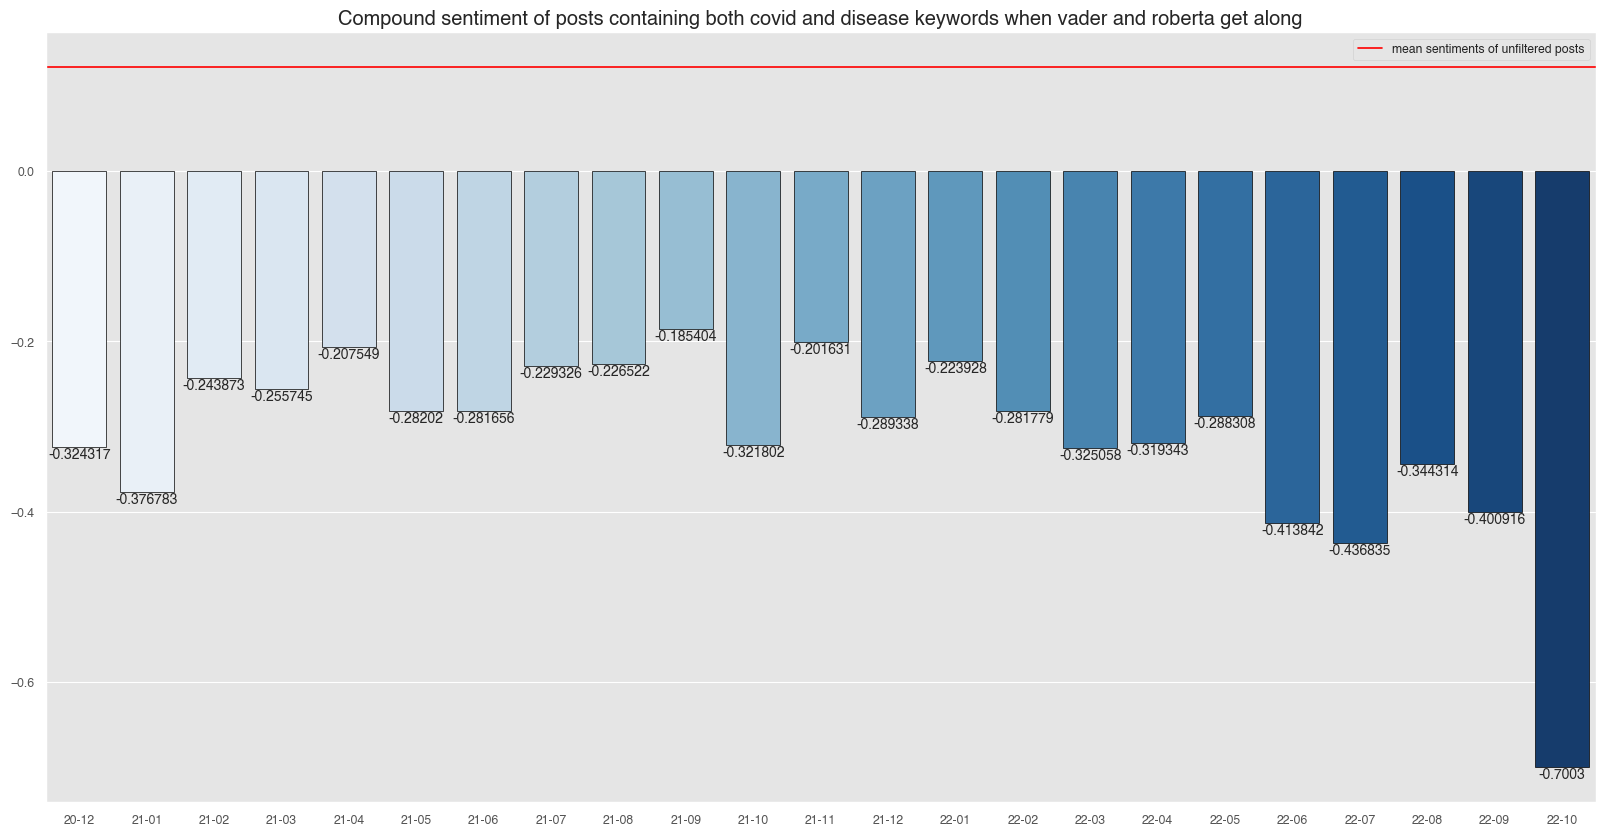

In [99]:
fig, ax1 = plt.subplots(figsize=(20,10), ncols=1, nrows=1)
ax1.set_title('Compound sentiment of posts containing both covid and disease keywords when vader and roberta get along')
sns.barplot(x=fare_df.groupby('created').count().compound_vader.keys(), y=avg_sen, edgecolor='black', palette='Blues', ax=ax1)
ax1.set_xlabel('')
ax1.bar_label(ax1.containers[0])
ax1.axhline(mean(avg_sentiments), color='r', label='mean sentiments of unfiltered posts')

plt.legend()
plt.show();